# Validation

This notebook contains examples of some of the simulations that have been used to validate Disimpy's functionality by comparing the simulated signals against analytical solutions and other simulators' results. Here, we simulate free diffusion and restricted diffusion inside cylinders and spheres.

In [2]:
# Import the required packages and modules

import os
import numpy as np
import matplotlib.pyplot as plt

from disimpy import gradients, simulations, utils
from disimpy.settings import GAMMA

In [3]:
# Define the simulation parameters

n_s = int(1e6)  # Number of random walkers
n_t = int(1e3)  # Number of time points
diffusivity = 2e-9  # In SI units (m^2/s)

## Free diffusion

In the case of free diffusion, the analytical expression for the signal is $S = S_0 \exp(-bD)$, where $S_0$ is the signal without diffusion-weighting, $b$ is the b-value, and $D$ is the diffusivity.

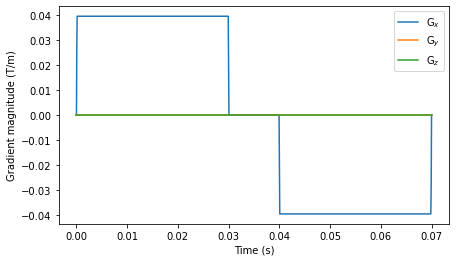

Starting simulation
Number of spins = 1000000
Number of steps = 1000
Step length = 9.171704949125858e-07 m
Step duration = 7.010014306151645e-05 s
Simulation finished.


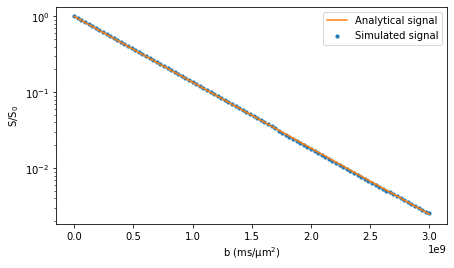

In [4]:
# Create a Stejskal-Tanner gradient array with ∆ = 40 ms and δ = 30 ms

T = 70e-3
gradient = np.zeros((1, 700, 3))
gradient[0, 1:300, 0] = 1
gradient[0, -300:-1, 0] = -1
bs = np.linspace(1, 3e9, 100)
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Show the waveform of the measurement with the highest b-value

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()


# Run the simulation with a higher number of spins because the signal almost
# completely decays by the highest b-value

substrate = {'type' : 'free'}
signals = simulations.simulation(int(1e6), diffusivity, gradient, dt, substrate)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(bs, np.exp(-bs * diffusivity), color='tab:orange')
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.legend(['Analytical signal', 'Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
plt.show()

## Restricted diffusion results comparison to MISST

Here, diffusion inside cylinders and spheres is simulated and the signals are compared to those calculated with [MISST](http://mig.cs.ucl.ac.uk/index.php?n=Tutorial.MISST) that uses matrix operators to calculate the time evolution of the diffusion signal inside simple geometries. The cylinder is simulated using a triangular mesh and the sphere as an analytically defined surface.

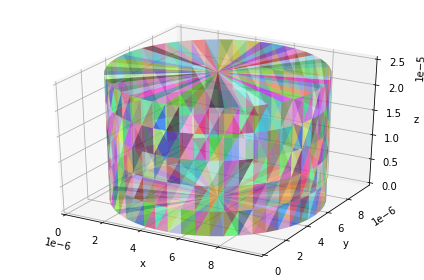

In [5]:
# Load and show triangular mesh used in the simulations

mesh_file = os.path.join(
    os.path.dirname(simulations.__file__), 'tests',
    'cyl_mesh_r5um_l25um_closed.npy')
mesh = np.load(mesh_file)
utils.show_mesh(mesh)

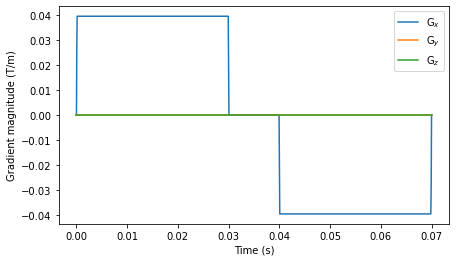

Starting simulation
Number of spins = 1000000
Number of steps = 1000
Step length = 9.171704949125858e-07 m
Step duration = 7.010014306151645e-05 s
Initialized random walker positions.
Simulation finished.


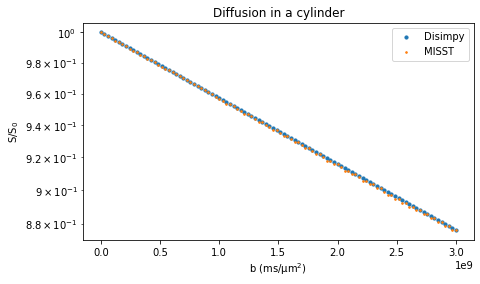

Starting simulation
Number of spins = 1000000
Number of steps = 1000
Step length = 9.171704949125858e-07 m
Step duration = 7.010014306151645e-05 s
Simulation finished.


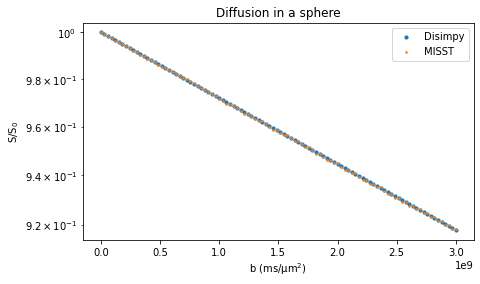

In [6]:
# Create a Stejskal-Tanner gradient array with ∆ = 40 ms and δ = 30 ms

T = 70e-3
gradient = np.zeros((1, 700, 3))
gradient[0, 1:300, 0] = 1
gradient[0, -300:-1, 0] = -1
bs = np.linspace(1, 3e9, 100)
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Show the waveform of the measurement with the highest b-value

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()


# Run the simulation

init_pos = np.zeros((n_s, 3))
init_pos[:, 0:2] = simulations._fill_circle(n_s, 5e-6)
init_pos += np.max(np.max(mesh, 0), 0) / 2
substrate = {'type': 'mesh',
             'mesh': mesh,
             'initial positions': init_pos}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Load MISST signals

tests_dir = os.path.join(os.path.dirname(gradients.__file__), 'tests')
misst_signals = np.loadtxt(os.path.join(tests_dir,
    'misst_cylinder_signal_smalldelta_30ms_bigdelta_40ms_radius_5um.txt'))


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.scatter(bs, misst_signals, s=10, marker='.')
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.legend(['Disimpy', 'MISST'])
ax.set_title('Diffusion in a cylinder')
ax.set_yscale('log')
plt.show()


# Run the simulation

substrate = {'type' : 'sphere',
             'radius' : 5e-6}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Load MISST signals

tests_dir = os.path.join(os.path.dirname(gradients.__file__), 'tests')
misst_signals = np.loadtxt(os.path.join(tests_dir,
    'misst_sphere_signal_smalldelta_30ms_bigdelta_40ms_radius_5um.txt'))


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.scatter(bs, misst_signals, s=10, marker='.')
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.legend(['Disimpy', 'MISST'])
ax.set_title('Diffusion in a sphere')
ax.set_yscale('log')
plt.show()

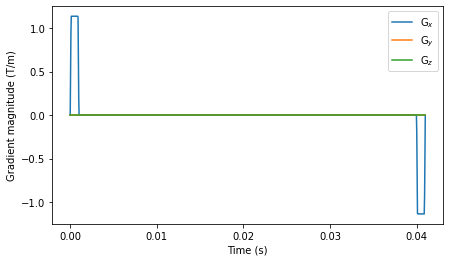

Starting simulation
Number of spins = 1000000
Number of steps = 1000
Step length = 7.022840835340996e-07 m
Step duration = 4.11002444987775e-05 s
Initialized random walker positions.
Simulation finished.


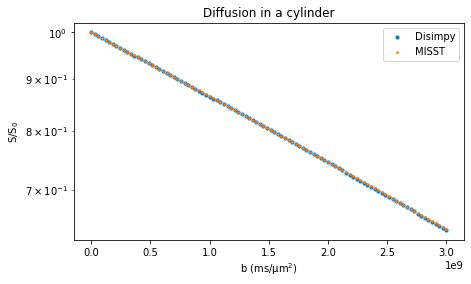

Starting simulation
Number of spins = 1000000
Number of steps = 1000
Step length = 7.022840835340996e-07 m
Step duration = 4.11002444987775e-05 s
Simulation finished.


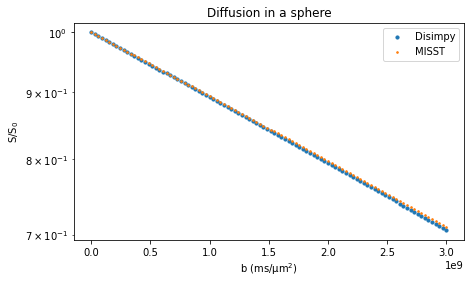

In [7]:
# Create a Stejskal-Tanner gradient array with ∆ = 40 ms and δ = 1 ms

T = 41e-3
gradient = np.zeros((1, 410, 3))
gradient[0, 1:10, 0] = 1
gradient[0, -10:-1, 0] = -1
bs = np.linspace(1, 3e9, 100)
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T / (gradient.shape[1] - 1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Show the waveform of the measurement with the highest b-value

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()


# Run the simulation

substrate = {'type': 'mesh',
             'mesh': mesh,
             'initial positions': init_pos}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Load MISST signals

tests_dir = os.path.join(os.path.dirname(gradients.__file__), 'tests')
misst_signals = np.loadtxt(os.path.join(tests_dir,
    'misst_cylinder_signal_smalldelta_1ms_bigdelta_40ms_radius_5um.txt'))


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.scatter(bs, misst_signals, s=10, marker='.')
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.legend(['Disimpy', 'MISST'])
ax.set_title('Diffusion in a cylinder')
ax.set_yscale('log')
plt.show()


# Run the simulation

substrate = {'type' : 'sphere',
             'radius' : 5e-6}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Load MISST signals

tests_dir = os.path.join(os.path.dirname(gradients.__file__), 'tests')
misst_signals = np.loadtxt(os.path.join(tests_dir,
    'misst_sphere_signal_smalldelta_1ms_bigdelta_40ms_radius_5um.txt'))


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(bs, signals / n_s, s=10, marker='o')
ax.scatter(bs, misst_signals, s=10, marker='.')
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
ax.legend(['Disimpy', 'MISST'])
ax.set_title('Diffusion in a sphere')
ax.set_yscale('log')
plt.show()

## Signal diffraction pattern

In the case of restricted diffusion in a cylinder perpendicular to the direction of the diffusion encoding gradient waveform with short pulses and long diffusion time, the signal minimum occurs at $0.61 · 2 · \pi/r$, where $r$ is the cylinder radius. Details are provided by [Avram et al](https://doi.org/10.1002/nbm.1277), for example.

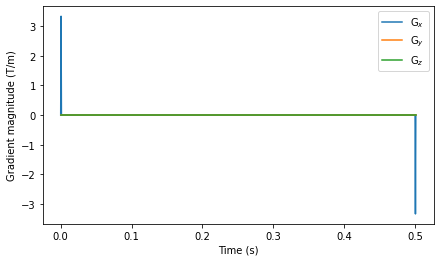

Starting simulation
Number of spins = 1000000
Number of steps = 1000
Step length = 2.4531648982524633e-06 m
Step duration = 0.0005015015015015015 s
Simulation finished.


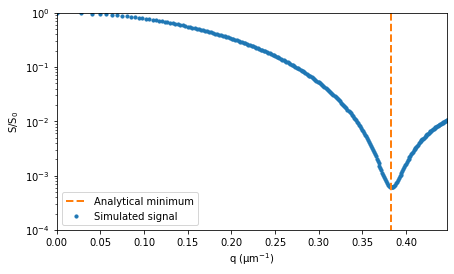

In [8]:
# Create a Stejskal-Tanner gradient array with ∆ = 0.5 s and δ = 0.1 ms

T = 501e-3
gradient = np.zeros((1, n_t, 3))
gradient[0, 1:2, 0] = 1
gradient[0, -2:-1, 0] = -1
dt = T / (gradient.shape[1] - 1)
bs = np.linspace(1, 1e11, 250)
gradient = np.concatenate([gradient for _ in bs], axis=0)
gradient = gradients.set_b(gradient, dt, bs)
q = gradients.calc_q(gradient, dt)
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Show the waveform of the measurement with the highest b-value

fig, ax = plt.subplots(1, figsize=(7, 4))
for i in range(3):
    ax.plot(np.linspace(0, T, n_t), gradient[-1, :, i])
ax.legend(['G$_x$', 'G$_y$', 'G$_z$'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Gradient magnitude (T/m)')
plt.show()


# Run the simulation

radius = 10e-6
substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1.]),
             'radius' : radius}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot the results

fig, ax = plt.subplots(1, figsize=(7, 4))
ax.scatter(1e-6 * qs, signals / n_s, s=10, marker='o')
minimum = 1e-6 * .61 * 2 * np.pi / radius
ax.plot([minimum, minimum], [0, 1], ls='--', lw=2, color='tab:orange')
ax.legend(['Analytical minimum', 'Simulated signal'])
ax.set_xlabel('q (μm$^{-1}$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
ax.set_ylim([1e-4, 1])
ax.set_xlim([0, max(1e-6 * qs)])
plt.show()